### Exercise Sheet 1

#### 1.3 Physics-informed function approximation 
Previously we used a dataset to learn solutions of the ODE:
\begin{align*}
    \partial_t^2 u(t) &= D(\partial_t u(t))^2 - g \\
    u(0) &= H \\
    \partial_t u(0) &= 0
\end{align*}
Now, we assume that the solution is not analytically known. Therefore we have to utilize the above differential equation in the training, which leads us to physics-informed neural networks.

For simplification of the implementation, we start with a fixed value for $D=0.02$.

In [21]:
import torch 

# Here all parameters are defined:
t_min, t_max = 0.0, 3.0
D = 0.02
g, H = 9.81, 50.0

# number of time points 
N_t = 50

train_iterations = 5000
learning_rate = 1.e-3

For the physics-informed training, the derivatives of the neural network have to be comupted. For this, we can use `torch.autograd.grad` (automatic differentiation). With `torch.autograd.grad` not only the gradients of neural networks can be computed but also the derivatives of general tensor operations. Here a small example for $t^2$:

In [22]:
# Create some data points
t = torch.linspace(0, 10, 11, requires_grad=True) # we need to set requires_grad=True, or else
                                                  # PyTorch will not be able to compute derivatives
u = t**2 # compute the square of the values
# Next up, we have to take the sum over all our values to compute the derivative. This has to do 
# with the implementation in PyTorch and we just have to remember to it.
# (the reason why is yet not so important)
u_sum = sum(u)
# Now we can call torch.autograd.grad:
u_t = torch.autograd.grad(u_sum, t, create_graph=True) # create_graph=True has to be set, so one can 
                                                       # later compute derivatives of higher order
# Autograd generally returns a tuple with multiple values, here we only need the first one:
print("Derivative with autograd gives:")
print(u_t[0])
print("Analytical derivative is:")
print(2*t)
print("They are in agreement!")

Derivative with autograd gives:
tensor([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.],
       grad_fn=<MulBackward0>)
Analytical derivative is:
tensor([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.],
       grad_fn=<MulBackward0>)
They are in agreement!


##### a) Working with `torch.autograd.grad`
Verify, with the help of `torch.autograd.grad`, that the previously given function
\begin{align*}
    u(t; D) &= \frac{1}{D} \left(\ln{\left( \frac{1+e^{-2\sqrt{Dg}t}}{2} \right)} - \sqrt{Dg} t \right) + H
\end{align*}
really solves the above ODE (e.g. numerically compute the derivatives and insert them into the ODE).

**Hint** : `torch.sqrt` only works for tensor-objects, you habe to either transform $D, g$ into tensors or import the `math` package for the root computation. 

In [23]:
import math
t = torch.linspace(t_min, t_max, N_t, requires_grad=True)

sqrt_term = math.sqrt(D * g)
u = H - 1/D * (torch.log((1 + torch.exp(-2*sqrt_term*t))/2.0) + sqrt_term*t)

u_t = torch.autograd.grad(sum(u), t, create_graph=True)[0]
u_tt = torch.autograd.grad(sum(u_t), t, create_graph=True)[0]

print(u_tt - D*u_t**2 + g)

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  9.5367e-07,
        -9.5367e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -9.5367e-07, -9.5367e-07,  0.0000e+00,  9.5367e-07, -9.5367e-07,
         0.0000e+00, -9.5367e-07, -9.5367e-07, -9.5367e-07, -9.5367e-07,
        -9.5367e-07,  0.0000e+00, -9.5367e-07,  0.0000e+00,  0.0000e+00,
        -9.5367e-07, -9.5367e-07,  0.0000e+00, -9.5367e-07,  0.0000e+00,
        -9.5367e-07,  0.0000e+00, -9.5367e-07,  0.0000e+00, -9.5367e-07,
        -9.5367e-07, -9.5367e-07, -9.5367e-07, -9.5367e-07, -9.5367e-07,
        -9.5367e-07, -9.5367e-07,  0.0000e+00, -9.5367e-07, -9.5367e-07,
        -9.5367e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00, -9.5367e-07],
       grad_fn=<AddBackward0>)


In the following cell, the time grid, a tensor for the initial time point and the neural network is given:

In [24]:
t = torch.linspace(t_min, t_max, N_t, requires_grad=True).reshape(N_t, 1)
t_zero = torch.tensor([0.0], requires_grad=True)

model = torch.nn.Sequential(
    torch.nn.Linear(1, 20), torch.nn.Tanh(), 
    torch.nn.Linear(20, 20), torch.nn.Tanh(), 
    torch.nn.Linear(20, 1)
) 

##### b) Implementing the physics-informed Loss
Use `torch.autograd.grad` to complete the training loop, by implementing the loss for the differential equation and both initial conditions.

Each condition needs it own loss function, which are already prepared at the top of the cell.

In [25]:
### Move everything to the GPU
if torch.cuda.is_available():
    model.to("cuda")
    t = t.to("cuda")
    t_zero = t_zero.to("cuda")

### For the loss, we take the mean squared error and Adam for optimization.
loss_fn_ode = torch.nn.MSELoss() 
loss_fn_initial_position = torch.nn.MSELoss() 
loss_fn_initial_speed = torch.nn.MSELoss() 

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training loop
for k in range(train_iterations):
    ### TODO: implement loss computation of all equations
    ### Loss for the differential equation: u_tt = D*(u_t)^2 - g
    u = model(t)
    u_t = torch.autograd.grad(sum(u), t, create_graph=True)[0]
    u_tt = torch.autograd.grad(sum(u_t), t, create_graph=True)[0]

    ode = u_tt - D*u_t**2 + g

    loss_ode = loss_fn_ode(ode, torch.zeros_like(ode))

    ### Loss for initial condition: u(0) = H
    u_zero = model(t_zero) - H
    loss_initial_position = loss_fn_initial_position(u_zero, torch.zeros_like(u_zero))

    ### Loss for the initial velocity: u_t(0) = 0
    u_zero_t = torch.autograd.grad(u_zero, t_zero, create_graph=True)[0]
    loss_initial_speed = loss_fn_initial_speed(u_zero_t, torch.zeros_like(u_zero_t))

    ### Add all loss terms
    total_loss = loss_ode + loss_initial_position + loss_initial_speed

    ### Shows current loss every 250 iterations:
    if k % 250 == 0 or k == train_iterations - 1:
        print("Loss at iteration %i / %i is %f" %(k, train_iterations, total_loss.item()))

    ### Optimization step
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

Loss at iteration 0 / 5000 is 2593.755859


Loss at iteration 250 / 5000 is 1826.885010
Loss at iteration 500 / 5000 is 1354.094727
Loss at iteration 750 / 5000 is 998.037476
Loss at iteration 1000 / 5000 is 730.804810
Loss at iteration 1250 / 5000 is 529.923035
Loss at iteration 1500 / 5000 is 374.715088
Loss at iteration 1750 / 5000 is 256.519226
Loss at iteration 2000 / 5000 is 169.028442
Loss at iteration 2250 / 5000 is 106.521324
Loss at iteration 2500 / 5000 is 63.730366
Loss at iteration 2750 / 5000 is 35.921154
Loss at iteration 3000 / 5000 is 18.949533
Loss at iteration 3250 / 5000 is 9.340476
Loss at iteration 3500 / 5000 is 4.356561
Loss at iteration 3750 / 5000 is 2.017897
Loss at iteration 4000 / 5000 is 1.036489
Loss at iteration 4250 / 5000 is 0.669598
Loss at iteration 4500 / 5000 is 0.543612
Loss at iteration 4750 / 5000 is 0.497535
Loss at iteration 4999 / 5000 is 0.473251


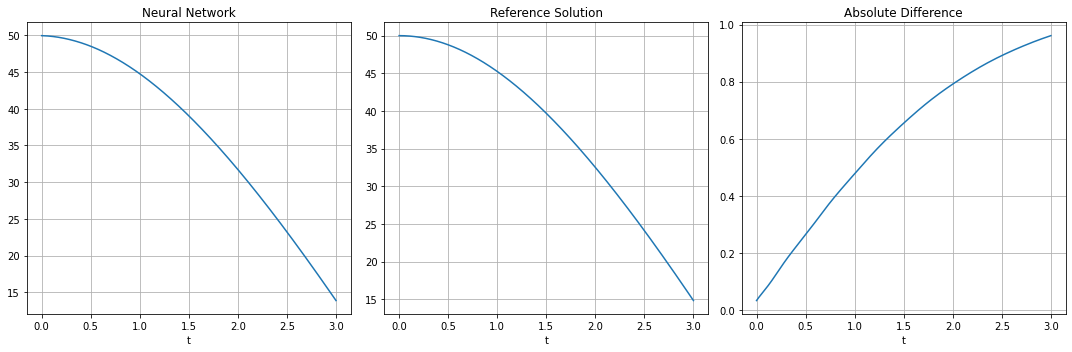

In [26]:
import math
### Here, a check of the accruarcy of the model:
t_plot = torch.linspace(t_min, t_max, 1000).reshape(-1, 1)

### First compute error:
model.to("cpu")
model_out = model(t_plot)

sqrt_term = math.sqrt(D * g)
real_out = H - 1/D * (torch.log((1 + torch.exp(-2*sqrt_term*t_plot))/2.0) + sqrt_term*t_plot)

### Plot solution
import matplotlib.pyplot as plt
plt.figure(0, figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(t_plot, model_out.detach())
plt.title("Neural Network")
plt.xlabel("t")
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(t_plot, real_out)
plt.title("Reference Solution")
plt.xlabel("t")
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(t_plot, torch.abs(real_out - model_out).detach())
plt.title("Absolute Difference")
plt.xlabel("t")
plt.grid()
plt.tight_layout()

In [27]:
# ### Bonus (variable D):
# ### Move everything to the GPU
# device = "cpu"
# if torch.cuda.is_available():
#     device = "cuda"

# N_D = 500
# D_min, D_max = 0.01, 1.0

# t = torch.linspace(t_min, t_max, N_t, device=device).reshape(N_t, 1).repeat((1, N_D)).T.unsqueeze(-1)
# t.requires_grad = True
# t_zero = torch.zeros((N_D, 1), requires_grad=True, device=device)
# D_values = D_min + (D_max - D_min) * torch.rand((N_D, 1), device=device).repeat(1, N_t).unsqueeze(-1)

# in_values = torch.cat((t, D_values), dim=2)
# in_values_zero = torch.cat((t_zero, D_values[:, :1, 0]), dim=1)

# # Input of model is (t, D)
# model = torch.nn.Sequential(
#     torch.nn.Linear(2, 20), torch.nn.Tanh(), 
#     torch.nn.Linear(20, 20), torch.nn.Tanh(), 
#     torch.nn.Linear(20, 1)
# ) 

# ### Move everything to the GPU
# if torch.cuda.is_available():
#     model.to("cuda")

# ### For the loss, we take the mean squared error and Adam for optimization.
# loss_fn_ode = torch.nn.MSELoss() 
# loss_fn_initial_position = torch.nn.MSELoss() 
# loss_fn_initial_speed = torch.nn.MSELoss() 

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ### Training loop
# for k in range(train_iterations):
#     ### TODO: implement loss computation of all equations
#     ### Loss for the differential equation: u_tt = D*(u_t)^2 - g
#     u = model(in_values)

#     u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
#     u_tt = torch.autograd.grad(u_t.sum(), t, create_graph=True)[0]

#     ode = u_tt - D_values*u_t**2 + g

#     loss_ode = loss_fn_ode(ode, torch.zeros_like(ode))

#     ### Loss for initial condition: u(0) = H
#     u_zero = model(in_values_zero) - H
#     loss_initial_position = loss_fn_initial_position(u_zero, torch.zeros_like(u_zero))

#     ### Loss for the initial velocity: u_t(0) = 0
#     u_zero_t = torch.autograd.grad(u_zero.sum(), t_zero, create_graph=True)[0]
#     loss_initial_speed = loss_fn_initial_speed(u_zero_t, torch.zeros_like(u_zero_t))

#     ### Add all loss terms
#     total_loss = loss_ode + loss_initial_position + loss_initial_speed

#     ### Shows current loss every 250 iterations:
#     if k % 250 == 0 or k == train_iterations - 1:
#         print("Loss at iteration %i / %i is %f" %(k, train_iterations, total_loss.item()))

#     ### Optimization step
#     optimizer.zero_grad()
#     total_loss.backward()
#     optimizer.step()

In [28]:
# import math
# ### Here, a check of the accruarcy of the model:
# D_test = 0.04
# t_plot = torch.linspace(t_min, t_max, 1000).reshape(-1, 1)
# in_plot = torch.zeros((1000, 2))
# in_plot[:, :1] = t_plot
# in_plot[:, 1:] = D_test
# ### First compute error:
# model.to("cpu")
# model_out = model(in_plot)

# sqrt_term = math.sqrt(D_test * g)
# real_out = H - 1/D_test * (torch.log((1 + torch.exp(-2*sqrt_term*t_plot))/2.0) + sqrt_term*t_plot)

# ### Plot solution
# import matplotlib.pyplot as plt
# plt.figure(0, figsize=(15, 5))
# plt.subplot(1, 3, 1)
# plt.plot(t_plot, model_out.detach())
# plt.title("Neural Network")
# plt.xlabel("t")
# plt.grid()
# plt.subplot(1, 3, 2)
# plt.plot(t_plot, real_out)
# plt.title("Reference Solution")
# plt.xlabel("t")
# plt.grid()
# plt.subplot(1, 3, 3)
# plt.plot(t_plot, torch.abs(real_out - model_out).detach())
# plt.title("Absolute Difference")
# plt.xlabel("t")
# plt.grid()
# plt.tight_layout()

In [29]:
# ## Implementation for FDM:

# t = torch.linspace(t_min, t_max, 500).reshape(500, 1)
# t_zero = torch.tensor([0.0])


# model.to("cuda")
# t = t.to("cuda")
# t_zero = t_zero.to("cuda")

# dt = t[1] - t[0] # step width
# t_delta = torch.tensor([dt], device="cuda")


# ### For the loss, we take the mean squared error and Adam for optimization.
# loss_fn_ode = torch.nn.MSELoss() 
# loss_fn_initial_position = torch.nn.MSELoss() 
# loss_fn_initial_speed = torch.nn.MSELoss() 

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ### Training loop
# for k in range(train_iterations):
#     ### Loss for the differential equation: u_tt = D*(u_t)^2 - g
#     u = model(t)
#     u_ghost_node = torch.cat((u[1:2], u), dim=0)
#     u_t = (u_ghost_node[2:] - u_ghost_node[:-2])/(2.0 * dt)
#     u_tt = (u_ghost_node[2:] - 2*u_ghost_node[1:-1] + u_ghost_node[:-2]) / dt**2

#     ode = u_tt - D*u_t**2 + g

#     loss_ode = loss_fn_ode(ode, torch.zeros_like(ode))

#     ### Loss for initial condition: u(0) = H
#     u_zero = model(t_zero)
#     loss_initial_position = loss_fn_initial_position(u_zero - H, torch.zeros_like(u_zero))

#     ### Loss for the initial velocity: u_t(0) = 0
#     u_delta_t = model(t_delta)
#     loss_initial_speed = loss_fn_initial_speed((u_delta_t - u_zero), torch.zeros_like(u_zero))

#     ### Add all loss terms
#     total_loss = loss_ode + loss_initial_position + loss_initial_speed

#     ### Shows current loss every 250 iterations:
#     if k % 250 == 0 or k == train_iterations - 1:
#         print("Loss at iteration %i / %i is %f" %(k, train_iterations, total_loss.item()))

#     ### Optimization step
#     optimizer.zero_grad()
#     total_loss.backward()
#     optimizer.step()
